In [13]:
import os
import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly

%matplotlib inline

In [3]:
# inputs
input_folder = '../csse_covid_19_data/csse_covid_19_daily_reports'
fmt = '.csv'

In [7]:
# grab and merge input csvs
data_files = glob.glob(os.path.join(input_folder, '*{}'.format(fmt)))

df = pd.DataFrame()
for i, filename in enumerate(data_files):
    new_data = pd.read_csv(filename)
    df = df.append(new_data)

/Users/yameng/workspace/python_envs/py3_default/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [40]:
# clean up data
def cleanup_date(x):
#     print(x)
    y, m, d = 0, 0, 0
    if 'T' in x:
        y, m, d = x.split('T')[0].split('-')
    elif ' ' in x:
        m, d, y = x.split(' ')[0].split('/')
    y = '20' + y if len(y) < 4 else y
    m = '0' + m if len(m) < 2 else m
    d = '0' + d if len(d) < 2 else d
    return '-'.join([y, m, d])

df['update_date'] = df['Last Update'].apply(lambda x: cleanup_date(x))
df = df.sort_values(by=['update_date'])

In [96]:
# overview
num_regions = df['Country/Region'].unique().shape[0]
num_days = df['update_date'].unique().shape[0]


num_confirmed_agg = df['Confirmed'].max()
num_death = df['Deaths'].max()
num_recovered = df['Recovered'].max()

case_fatality_rate = num_death / num_confirmed_agg

latest_date = df['update_date'].max()

print("Overview: till {}, in {} days, Covid-19 has spread into {} Countries/ Regions".format(latest_date, num_days, num_regions))
print("Total confirmed cases: {}, recoverd: {}, death: {}".format(int(num_confirmed_agg), int(num_recovered), int(num_death)))
print("Case Fatality Rate: {:04.2f}%".format(case_fatality_rate * 100))

Overview: till 2020-03-16, in 55 days, Covid-19 has spread into 186 Countries/ Regions
Total confirmed cases: 67798, recoverd: 55142, death: 3099
Case Fatality Rate: 4.57%


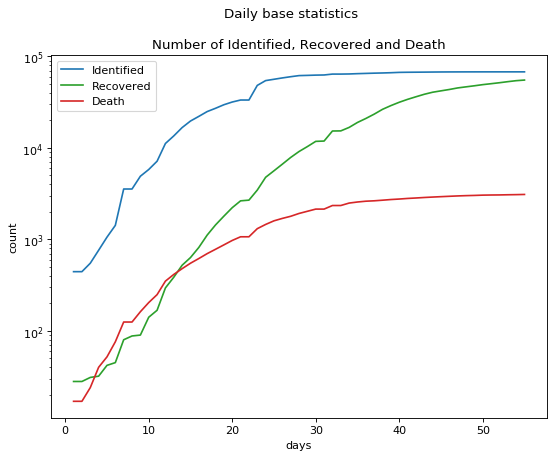

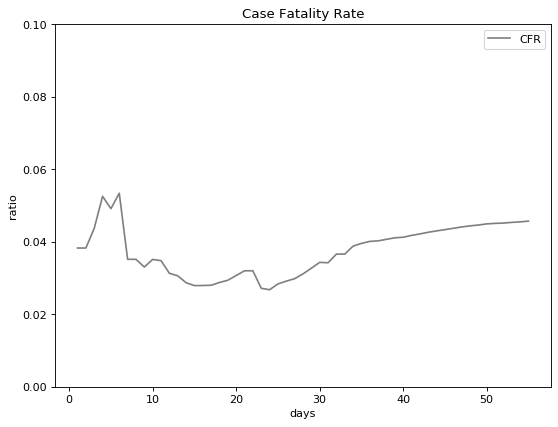

In [94]:
# time based aggregation
df_time = df.groupby(by='update_date')

date = []
days = []
num_identified = [0]
num_recovered = [0]
num_deaths = [0]
cfrs = []
for i, (t, frame) in enumerate(df_time):
    date.append(t)
    days.append(i + 1)
    num_identified.append(frame['Confirmed'].max())
    num_recovered.append(frame['Recovered'].max())
    num_deaths.append(frame['Deaths'].max())
    cfrs.append(num_deaths[-1] / num_identified[-1])

num_identified = num_identified[1: ]
num_recovered = num_recovered[1: ]
num_deaths = num_deaths[1: ]

fig, axs = plt.subplots(1, sharex=True, figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Daily base statistics')

axs.plot(days, num_identified)
axs.set_title('Number of Identified, Recovered and Death')
axs.set(xlabel='days', ylabel='count')
axs.set_yscale('log')

axs.plot(days, num_recovered, 'tab:green')
# axs.set_title('Number of Recovered')
axs.set(xlabel='days', ylabel='count')
axs.set_yscale('log')

axs.plot(days, num_deaths, 'tab:red')
# axs.set_title('Number of Deaths')
axs.set(xlabel='days', ylabel='count')
axs.set_yscale('log')

axs.legend(['Identified', 'Recovered', 'Death'])

for axi in fig.get_axes():
    axi.label_outer()

fig, ax = plt.subplots(1, figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
ax.plot(days, cfrs, 'tab:gray')
ax.set_title('Case Fatality Rate')
ax.set(xlabel='days', ylabel='ratio')
ax.set_ylim(0, 0.1)
ax.legend(['CFR'])


In [45]:
df.head()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,update_date
3,1.0,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Fujian,NaN,2020-01-22
24,2.0,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Shandong,NaN,2020-01-22
8,4.0,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Hainan,NaN,2020-01-22
23,NaN,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Shaanxi,NaN,2020-01-22
21,1.0,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Ningxia,NaN,2020-01-22


In [39]:
df[df['update_date'] == '2020-31-01']

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,update_date
56,1.0,Cambodia,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01
57,1.0,Sri Lanka,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01
58,1.0,Finland,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01
55,1.0,Canada,NaN,1/31/2020 23:59,NaN,NaN,British Columbia,NaN,2020-31-01
60,1.0,India,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01
...,...,...,...,...,...,...,...,...,...
24,29.0,Mainland China,NaN,1/31/2020 23:59,NaN,NaN,Gansu,NaN,2020-31-01
23,29.0,Mainland China,NaN,1/31/2020 23:59,NaN,NaN,Guizhou,2.0,2020-31-01
22,32.0,Mainland China,NaN,1/31/2020 23:59,NaN,NaN,Tianjin,NaN,2020-31-01
36,13.0,Singapore,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01


In [51]:
df_time